#Sentiment Analysis with Pre-trained Google BERT Model

Let’s start the sentiment analysis with BERT! We used Google Colab to run our code. 
Firstly, let’s install libraries we will need.

In [0]:
# import libraries
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

BERT has been added to Tensorflow Hub as a loadable module. We will train our prediction model to predict whether a yelp review is positive or negative using BERT in Tensorflow. Let’s install bert-tensorflow and BERT's python package then.

In [4]:
!pip install bert-tensorflow

Install BERT's python package

In [5]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

# Load Data

Then let’s download the Yelp Reviews Polarity dataset from https://course.fast.ai/datasets and place them in a directory. The dataset contains reviews from yelp and has train and test two csv files. We download the data to Google Colab and read the data into panda data frame.


In [6]:
!wget https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz

--2020-02-11 04:56:27--  https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.105.29
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.105.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166373201 (159M) [application/x-tar]
Saving to: ‘yelp_review_polarity_csv.tgz’

yelp_review_polarit 100%[===================>] 158.67M  55.2MB/s    in 2.9s    

2020-02-11 04:56:30 (55.2 MB/s) - ‘yelp_review_polarity_csv.tgz’ saved [166373201/166373201]



In [7]:
!tar zxvf ./yelp_review_polarity_csv.tgz 

yelp_review_polarity_csv/
yelp_review_polarity_csv/train.csv
yelp_review_polarity_csv/readme.txt
yelp_review_polarity_csv/test.csv


In [0]:
train = pd.read_csv('./yelp_review_polarity_csv/train.csv', header = None)
test = pd.read_csv('./yelp_review_polarity_csv/test.csv', header = None)

This dataset has 280,000 training samples and 19,000 test samples in each polarity. We took a sample of 6000 for training and testing respectively for a faster training speed.

In [0]:
train = train.sample(6000)
test = test.sample(6000)

In [10]:
train.columns

Int64Index([0, 1], dtype='int64')

Then let’s reset the index in the train and test datasets and print the first 5 rows of each dataset for a better understanding. 

In [0]:
# reset index
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

In [12]:
train.head()

,0,1
0,2,Dr. Lee was my 1st Dental Office in Las Vegas ...
1,2,It's been a while since I wrote my initial rev...
2,2,This is place is full of character and charm.....
3,1,I will never come to this native ever again.\n...
4,1,I decided to get gel on my toes. One lady told...


In [13]:
test.head()

,0,1
0,1,1 star for Gordon Ramsay just because we love ...
1,2,My husband and I had a wonderful dinner here w...
2,2,"Great lunch spot, good sandwich and salads. Th..."
3,2,One of the coolest places I would've never exp...
4,2,Great food drinks service but was high priced


The dataset has two columns for the label and the text. In the label column, they use 1 and 2 to indicate negative reviews and positive reviews. We changed this to 0 and 1 labelling, where 0 indicates a negative review, and 1 indicates a positive review. Then we named those two columns as polarity and sentence.

In [0]:
# substitute 1&2 with 0&1
# 0 means negative reviews, 1 means positive reviews
train[0] = (train[0] == 2).astype(int)
test[0] = (test[0] == 2).astype(int)

In [0]:
# name columns 
train.columns = ['polarity', 'sentence']
test.columns = ['polarity', 'sentence']

Next, let’s install matplotlib.pyplot to plot the distribution of the polarity in each dataset.

In [0]:
import matplotlib.pyplot as plt

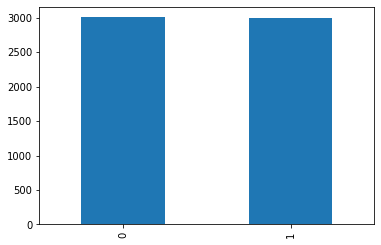

In [17]:
# distribution of the polarity in train dataset
train['polarity'].value_counts().plot(kind='bar');

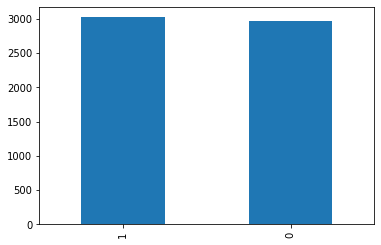

In [18]:
# distribution of the polarity in test dataset
test['polarity'].value_counts().plot(kind='bar');

#Data Cleaning and Preprocessing
Transform data into a format that  BERT accepts.

Now let’s clean the data before next step. We firstly define a function to remove lower text, punctuation, empty tokens and words with only one letter and then apply it to train and test datasets.

In [0]:
import string

In [0]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return (text)

In [0]:
# clean text data
train["sentence"] = train["sentence"].apply(lambda x: clean_text(x))
test["sentence"] = test["sentence"].apply(lambda x: clean_text(x))

To feed data in BERT, we need to transform data into a format BERT understands. First, we use InputExample class from BERT's run_classifier code to create examples from the data. “guid” is the unique id for each review. “Text_a” is the reviews we want to predict. “Text_b” doesn't apply to our task, so we can leave it blank. “Label” is the polarity in our dataset.

In [0]:
# Use the InputExample class from BERT's run_classifier to create examples from the data

train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # unique ID
                                                                   text_a = x['sentence'], # the text we want to classify
                                                                   text_b = None, 
                                                                   label = x['polarity']), axis = 1) #  label of the text

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x['sentence'], 
                                                                   text_b = None, 
                                                                   label = x['polarity']), axis = 1)

In addition, we need to preprocess our data so that it matches the data BERT was trained on:

1. Lowercase our text for BERT lowercase model
2. Tokenize 
3. Break words into WordPieces 
4. Map words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens 
6. Append "index" and "segment" tokens to each input

Let’s first load a vocabulary file and lowercasing text from the BERT tf hub module and created a tokenizer to break words into word pieces:





In [23]:
# load a vocabulary file and lowercasing text from the BERT tf hub module:
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

# created a tokenizer to break words into word pieces:
def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])

  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Then set sequences to be at most 128 tokens long and call run_classifier.convert_examples_to_features on InputExamples to convert them into features BERT understands.

In [24]:
# set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# label list
label_list = [0, 1]
# Convert train and test features to InputFeatures 
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 6000


INFO:tensorflow:Writing example 0 of 6000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] dr lee was my dental office in las vegas and have to admit he is very knowledge ##able gentle and down to earth dr lee is awesome he has the best and latest technology for his patients to make it very comfortable while you are there to get your teeth clean or wisdom tooth pulled like me dr park is also great and thank you for making life so much easier without so much pain this dental office is very up to date and has modern hip decor clean gives great service great dental h ##y ##gie ##nist ##s and last but not least has the best ##est receptionist ##s that greet ##s you when you first walk in the door [SEP]


INFO:tensorflow:tokens: [CLS] dr lee was my dental office in las vegas and have to admit he is very knowledge ##able gentle and down to earth dr lee is awesome he has the best and latest technology for his patients to make it very comfortable while you are there to get your teeth clean or wisdom tooth pulled like me dr park is also great and thank you for making life so much easier without so much pain this dental office is very up to date and has modern hip decor clean gives great service great dental h ##y ##gie ##nist ##s and last but not least has the best ##est receptionist ##s that greet ##s you when you first walk in the door [SEP]


INFO:tensorflow:input_ids: 101 2852 3389 2001 2026 11394 2436 1999 5869 7136 1998 2031 2000 6449 2002 2003 2200 3716 3085 7132 1998 2091 2000 3011 2852 3389 2003 12476 2002 2038 1996 2190 1998 6745 2974 2005 2010 5022 2000 2191 2009 2200 6625 2096 2017 2024 2045 2000 2131 2115 4091 4550 2030 9866 11868 2766 2066 2033 2852 2380 2003 2036 2307 1998 4067 2017 2005 2437 2166 2061 2172 6082 2302 2061 2172 3255 2023 11394 2436 2003 2200 2039 2000 3058 1998 2038 2715 5099 25545 4550 3957 2307 2326 2307 11394 1044 2100 11239 26942 2015 1998 2197 2021 2025 2560 2038 1996 2190 4355 23775 2015 2008 17021 2015 2017 2043 2017 2034 3328 1999 1996 2341 102 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2852 3389 2001 2026 11394 2436 1999 5869 7136 1998 2031 2000 6449 2002 2003 2200 3716 3085 7132 1998 2091 2000 3011 2852 3389 2003 12476 2002 2038 1996 2190 1998 6745 2974 2005 2010 5022 2000 2191 2009 2200 6625 2096 2017 2024 2045 2000 2131 2115 4091 4550 2030 9866 11868 2766 2066 2033 2852 2380 2003 2036 2307 1998 4067 2017 2005 2437 2166 2061 2172 6082 2302 2061 2172 3255 2023 11394 2436 2003 2200 2039 2000 3058 1998 2038 2715 5099 25545 4550 3957 2307 2326 2307 11394 1044 2100 11239 26942 2015 1998 2197 2021 2025 2560 2038 1996 2190 4355 23775 2015 2008 17021 2015 2017 2043 2017 2034 3328 1999 1996 2341 102 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] it ' s been while since wrote my initial review for bf ##g but went back few days ago and some things have changed so i ' m off ownership of the place has changed so that was kind of shock ##er because was so accustomed to jin and his awesome customer service the new staff is cool and the customer service is average now but in my old review mentioned that felt like friend or family member rather than just customer that statement is no longer true it is because of this reason that my rating has dropped . \ n \ n ##not to worry though . \ n \ n ##not ##hing about the food has changed everything have said about the food [SEP]


INFO:tensorflow:tokens: [CLS] it ' s been while since wrote my initial review for bf ##g but went back few days ago and some things have changed so i ' m off ownership of the place has changed so that was kind of shock ##er because was so accustomed to jin and his awesome customer service the new staff is cool and the customer service is average now but in my old review mentioned that felt like friend or family member rather than just customer that statement is no longer true it is because of this reason that my rating has dropped . \ n \ n ##not to worry though . \ n \ n ##not ##hing about the food has changed everything have said about the food [SEP]


INFO:tensorflow:input_ids: 101 2009 1005 1055 2042 2096 2144 2626 2026 3988 3319 2005 28939 2290 2021 2253 2067 2261 2420 3283 1998 2070 2477 2031 2904 2061 1045 1005 1049 2125 6095 1997 1996 2173 2038 2904 2061 2008 2001 2785 1997 5213 2121 2138 2001 2061 17730 2000 9743 1998 2010 12476 8013 2326 1996 2047 3095 2003 4658 1998 1996 8013 2326 2003 2779 2085 2021 1999 2026 2214 3319 3855 2008 2371 2066 2767 2030 2155 2266 2738 2084 2074 8013 2008 4861 2003 2053 2936 2995 2009 2003 2138 1997 2023 3114 2008 2026 5790 2038 3333 1012 1032 1050 1032 1050 17048 2000 4737 2295 1012 1032 1050 1032 1050 17048 12053 2055 1996 2833 2038 2904 2673 2031 2056 2055 1996 2833 102


INFO:tensorflow:input_ids: 101 2009 1005 1055 2042 2096 2144 2626 2026 3988 3319 2005 28939 2290 2021 2253 2067 2261 2420 3283 1998 2070 2477 2031 2904 2061 1045 1005 1049 2125 6095 1997 1996 2173 2038 2904 2061 2008 2001 2785 1997 5213 2121 2138 2001 2061 17730 2000 9743 1998 2010 12476 8013 2326 1996 2047 3095 2003 4658 1998 1996 8013 2326 2003 2779 2085 2021 1999 2026 2214 3319 3855 2008 2371 2066 2767 2030 2155 2266 2738 2084 2074 8013 2008 4861 2003 2053 2936 2995 2009 2003 2138 1997 2023 3114 2008 2026 5790 2038 3333 1012 1032 1050 1032 1050 17048 2000 4737 2295 1012 1032 1050 1032 1050 17048 12053 2055 1996 2833 2038 2904 2673 2031 2056 2055 1996 2833 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] this is place is full of character and charm and whiskey like lot of whiskey we ducked out of the rain while on short edinburgh vacation to warm up and try some single mal ##ts it ' s cozy has free wi ##fi and everyone was really nice upon seeing that we were whiskey enthusiasts the owner maybe manager pulled up chair and shared some favorites with us he even pulled out bunch of whiskey books and took us to school educational and boo ##zation ##al think that ' s word there was nice fell ##a playing some pub tunes and it put us all in the happy vacation - y spirit good times [SEP]


INFO:tensorflow:tokens: [CLS] this is place is full of character and charm and whiskey like lot of whiskey we ducked out of the rain while on short edinburgh vacation to warm up and try some single mal ##ts it ' s cozy has free wi ##fi and everyone was really nice upon seeing that we were whiskey enthusiasts the owner maybe manager pulled up chair and shared some favorites with us he even pulled out bunch of whiskey books and took us to school educational and boo ##zation ##al think that ' s word there was nice fell ##a playing some pub tunes and it put us all in the happy vacation - y spirit good times [SEP]


INFO:tensorflow:input_ids: 101 2023 2003 2173 2003 2440 1997 2839 1998 11084 1998 13803 2066 2843 1997 13803 2057 13781 2041 1997 1996 4542 2096 2006 2460 5928 10885 2000 4010 2039 1998 3046 2070 2309 15451 3215 2009 1005 1055 26931 2038 2489 15536 8873 1998 3071 2001 2428 3835 2588 3773 2008 2057 2020 13803 20305 1996 3954 2672 3208 2766 2039 3242 1998 4207 2070 20672 2007 2149 2002 2130 2766 2041 9129 1997 13803 2808 1998 2165 2149 2000 2082 4547 1998 22017 9276 2389 2228 2008 1005 1055 2773 2045 2001 3835 3062 2050 2652 2070 9047 13281 1998 2009 2404 2149 2035 1999 1996 3407 10885 1011 1061 4382 2204 2335 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2023 2003 2173 2003 2440 1997 2839 1998 11084 1998 13803 2066 2843 1997 13803 2057 13781 2041 1997 1996 4542 2096 2006 2460 5928 10885 2000 4010 2039 1998 3046 2070 2309 15451 3215 2009 1005 1055 26931 2038 2489 15536 8873 1998 3071 2001 2428 3835 2588 3773 2008 2057 2020 13803 20305 1996 3954 2672 3208 2766 2039 3242 1998 4207 2070 20672 2007 2149 2002 2130 2766 2041 9129 1997 13803 2808 1998 2165 2149 2000 2082 4547 1998 22017 9276 2389 2228 2008 1005 1055 2773 2045 2001 3835 3062 2050 2652 2070 9047 13281 1998 2009 2404 2149 2035 1999 1996 3407 10885 1011 1061 4382 2204 2335 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] will never come to this native ever again . \ n ##fi ##rst we sit down and order the drinks but our waitress forget ##s till after we are almost done with our app ##eti ##zers nt ##hat ##s was okay . . . . maybe she was having bad night . . . \ n \ nt ##hen she brings us the wrong order and says that ##s what we ordered . . . honestly order the same thing every single time ns ##he keeps making it sound like its our fault . . . \ no ##ka ##y . . . \ n \ nt ##hen when we are done eating we stacked our plates to show her that we were ready to pay [SEP]


INFO:tensorflow:tokens: [CLS] will never come to this native ever again . \ n ##fi ##rst we sit down and order the drinks but our waitress forget ##s till after we are almost done with our app ##eti ##zers nt ##hat ##s was okay . . . . maybe she was having bad night . . . \ n \ nt ##hen she brings us the wrong order and says that ##s what we ordered . . . honestly order the same thing every single time ns ##he keeps making it sound like its our fault . . . \ no ##ka ##y . . . \ n \ nt ##hen when we are done eating we stacked our plates to show her that we were ready to pay [SEP]


INFO:tensorflow:input_ids: 101 2097 2196 2272 2000 2023 3128 2412 2153 1012 1032 1050 8873 12096 2057 4133 2091 1998 2344 1996 8974 2021 2256 13877 5293 2015 6229 2044 2057 2024 2471 2589 2007 2256 10439 20624 16750 23961 12707 2015 2001 3100 1012 1012 1012 1012 2672 2016 2001 2383 2919 2305 1012 1012 1012 1032 1050 1032 23961 10222 2016 7545 2149 1996 3308 2344 1998 2758 2008 2015 2054 2057 3641 1012 1012 1012 9826 2344 1996 2168 2518 2296 2309 2051 24978 5369 7906 2437 2009 2614 2066 2049 2256 6346 1012 1012 1012 1032 2053 2912 2100 1012 1012 1012 1032 1050 1032 23961 10222 2043 2057 2024 2589 5983 2057 16934 2256 7766 2000 2265 2014 2008 2057 2020 3201 2000 3477 102


INFO:tensorflow:input_ids: 101 2097 2196 2272 2000 2023 3128 2412 2153 1012 1032 1050 8873 12096 2057 4133 2091 1998 2344 1996 8974 2021 2256 13877 5293 2015 6229 2044 2057 2024 2471 2589 2007 2256 10439 20624 16750 23961 12707 2015 2001 3100 1012 1012 1012 1012 2672 2016 2001 2383 2919 2305 1012 1012 1012 1032 1050 1032 23961 10222 2016 7545 2149 1996 3308 2344 1998 2758 2008 2015 2054 2057 3641 1012 1012 1012 9826 2344 1996 2168 2518 2296 2309 2051 24978 5369 7906 2437 2009 2614 2066 2049 2256 6346 1012 1012 1012 1032 2053 2912 2100 1012 1012 1012 1032 1050 1032 23961 10222 2043 2057 2024 2589 5983 2057 16934 2256 7766 2000 2265 2014 2008 2057 2020 3201 2000 3477 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] decided to get gel on my toes one lady told me price and when went to check out it cost ##ed just for my toes imagine if had time to get my fingers nail done what rip off . \ no ##ops wrong location sorry meant for tr ##op ##ica ##na and ar ##by rd [SEP]


INFO:tensorflow:tokens: [CLS] decided to get gel on my toes one lady told me price and when went to check out it cost ##ed just for my toes imagine if had time to get my fingers nail done what rip off . \ no ##ops wrong location sorry meant for tr ##op ##ica ##na and ar ##by rd [SEP]


INFO:tensorflow:input_ids: 101 2787 2000 2131 21500 2006 2026 10393 2028 3203 2409 2033 3976 1998 2043 2253 2000 4638 2041 2009 3465 2098 2074 2005 2026 10393 5674 2065 2018 2051 2000 2131 2026 3093 13774 2589 2054 10973 2125 1012 1032 2053 11923 3308 3295 3374 3214 2005 19817 7361 5555 2532 1998 12098 3762 16428 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2787 2000 2131 21500 2006 2026 10393 2028 3203 2409 2033 3976 1998 2043 2253 2000 4638 2041 2009 3465 2098 2074 2005 2026 10393 5674 2065 2018 2051 2000 2131 2026 3093 13774 2589 2054 10973 2125 1012 1032 2053 11923 3308 3295 3374 3214 2005 19817 7361 5555 2532 1998 12098 3762 16428 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 0 of 6000


INFO:tensorflow:Writing example 0 of 6000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] star for gordon ramsay just because we love his show and star for the runner / bus ##boy for our table . \ n \ nun ##like other steak ##houses the hostess ##es here are more on the younger chi ##c side versus the usual professional looking hostess ##es at other steak ##houses when walked in to look for my party ' s table the hostess just let me in without asking if needed help on finding my party we waited for good minutes before our server brought us drink menu and minutes later the food menu the server was friendly and professional on introducing different types of meat ##s and we were excited to try the bone - in rib ##eye lobster tail and the [SEP]


INFO:tensorflow:tokens: [CLS] star for gordon ramsay just because we love his show and star for the runner / bus ##boy for our table . \ n \ nun ##like other steak ##houses the hostess ##es here are more on the younger chi ##c side versus the usual professional looking hostess ##es at other steak ##houses when walked in to look for my party ' s table the hostess just let me in without asking if needed help on finding my party we waited for good minutes before our server brought us drink menu and minutes later the food menu the server was friendly and professional on introducing different types of meat ##s and we were excited to try the bone - in rib ##eye lobster tail and the [SEP]


INFO:tensorflow:input_ids: 101 2732 2005 5146 19460 2074 2138 2057 2293 2010 2265 1998 2732 2005 1996 5479 1013 3902 11097 2005 2256 2795 1012 1032 1050 1032 16634 10359 2060 21475 15666 1996 22566 2229 2182 2024 2062 2006 1996 3920 9610 2278 2217 6431 1996 5156 2658 2559 22566 2229 2012 2060 21475 15666 2043 2939 1999 2000 2298 2005 2026 2283 1005 1055 2795 1996 22566 2074 2292 2033 1999 2302 4851 2065 2734 2393 2006 4531 2026 2283 2057 4741 2005 2204 2781 2077 2256 8241 2716 2149 4392 12183 1998 2781 2101 1996 2833 12183 1996 8241 2001 5379 1998 2658 2006 10449 2367 4127 1997 6240 2015 1998 2057 2020 7568 2000 3046 1996 5923 1011 1999 19395 17683 27940 5725 1998 1996 102


INFO:tensorflow:input_ids: 101 2732 2005 5146 19460 2074 2138 2057 2293 2010 2265 1998 2732 2005 1996 5479 1013 3902 11097 2005 2256 2795 1012 1032 1050 1032 16634 10359 2060 21475 15666 1996 22566 2229 2182 2024 2062 2006 1996 3920 9610 2278 2217 6431 1996 5156 2658 2559 22566 2229 2012 2060 21475 15666 2043 2939 1999 2000 2298 2005 2026 2283 1005 1055 2795 1996 22566 2074 2292 2033 1999 2302 4851 2065 2734 2393 2006 4531 2026 2283 2057 4741 2005 2204 2781 2077 2256 8241 2716 2149 4392 12183 1998 2781 2101 1996 2833 12183 1996 8241 2001 5379 1998 2658 2006 10449 2367 4127 1997 6240 2015 1998 2057 2020 7568 2000 3046 1996 5923 1011 1999 19395 17683 27940 5725 1998 1996 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] my husband and had wonderful dinner here while visiting montreal it is hidden away on side street an escape from the hub ##bu ##b of st denis the food was gorgeous delicious beautiful innovative and very inexpensive for what it is the space is cozy and pretty with just few tables the chef is true artist and the waiter struck the ideal balance between being uno ##bt ##rus ##ive and at ##ten ##tive it ' s real gem my favorite meal in montreal [SEP]


INFO:tensorflow:tokens: [CLS] my husband and had wonderful dinner here while visiting montreal it is hidden away on side street an escape from the hub ##bu ##b of st denis the food was gorgeous delicious beautiful innovative and very inexpensive for what it is the space is cozy and pretty with just few tables the chef is true artist and the waiter struck the ideal balance between being uno ##bt ##rus ##ive and at ##ten ##tive it ' s real gem my favorite meal in montreal [SEP]


INFO:tensorflow:input_ids: 101 2026 3129 1998 2018 6919 4596 2182 2096 5873 5548 2009 2003 5023 2185 2006 2217 2395 2019 4019 2013 1996 9594 8569 2497 1997 2358 11064 1996 2833 2001 9882 12090 3376 9525 1998 2200 23766 2005 2054 2009 2003 1996 2686 2003 26931 1998 3492 2007 2074 2261 7251 1996 10026 2003 2995 3063 1998 1996 15610 4930 1996 7812 5703 2090 2108 27776 19279 7946 3512 1998 2012 6528 6024 2009 1005 1055 2613 17070 2026 5440 7954 1999 5548 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2026 3129 1998 2018 6919 4596 2182 2096 5873 5548 2009 2003 5023 2185 2006 2217 2395 2019 4019 2013 1996 9594 8569 2497 1997 2358 11064 1996 2833 2001 9882 12090 3376 9525 1998 2200 23766 2005 2054 2009 2003 1996 2686 2003 26931 1998 3492 2007 2074 2261 7251 1996 10026 2003 2995 3063 1998 1996 15610 4930 1996 7812 5703 2090 2108 27776 19279 7946 3512 1998 2012 6528 6024 2009 1005 1055 2613 17070 2026 5440 7954 1999 5548 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] great lunch spot good sandwich and salad ##s the as ##para ##gus sandwich is my favorite [SEP]


INFO:tensorflow:tokens: [CLS] great lunch spot good sandwich and salad ##s the as ##para ##gus sandwich is my favorite [SEP]


INFO:tensorflow:input_ids: 101 2307 6265 3962 2204 11642 1998 16521 2015 1996 2004 28689 12349 11642 2003 2026 5440 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2307 6265 3962 2204 11642 1998 16521 2015 1996 2004 28689 12349 11642 2003 2026 5440 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] one of the cool ##est places would ' ve never expected to find in uptown charlotte feel like stepped off church st and into little corner of the emerald isle definitely worth visit grab an irish pin ##t in this cozy pub and enjoy some good darts or soccer on the tv [SEP]


INFO:tensorflow:tokens: [CLS] one of the cool ##est places would ' ve never expected to find in uptown charlotte feel like stepped off church st and into little corner of the emerald isle definitely worth visit grab an irish pin ##t in this cozy pub and enjoy some good darts or soccer on the tv [SEP]


INFO:tensorflow:input_ids: 101 2028 1997 1996 4658 4355 3182 2052 1005 2310 2196 3517 2000 2424 1999 28539 5904 2514 2066 3706 2125 2277 2358 1998 2046 2210 3420 1997 1996 14110 8842 5791 4276 3942 6723 2019 3493 9231 2102 1999 2023 26931 9047 1998 5959 2070 2204 17493 2030 4715 2006 1996 2694 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2028 1997 1996 4658 4355 3182 2052 1005 2310 2196 3517 2000 2424 1999 28539 5904 2514 2066 3706 2125 2277 2358 1998 2046 2210 3420 1997 1996 14110 8842 5791 4276 3942 6723 2019 3493 9231 2102 1999 2023 26931 9047 1998 5959 2070 2204 17493 2030 4715 2006 1996 2694 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] great food drinks service but was high priced [SEP]


INFO:tensorflow:tokens: [CLS] great food drinks service but was high priced [SEP]


INFO:tensorflow:input_ids: 101 2307 2833 8974 2326 2021 2001 2152 21125 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2307 2833 8974 2326 2021 2001 2152 21125 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


#Build a model

After we finished the data cleaning and preprocessing part. Let’s start to build the model!
Function “create_model” loads the BERT tf hub module again. And then it creates a single new layer that will be trained to adapt BERT to sentiment task. The strategy of using a mostly trained model is called fine-tuning. In this function, we first create a classification model, then use "pooled_output" for classification tasks on an entire sentence and use "sequence_outputs" for token-level output. What’s more, we create a layer to tune for politeness data and use dropout to help prevent overfitting. Next, we convert labels into one-hot encoding. Finally, we predict labels and the probabilities and compute loss between predicted and actual label.


In [0]:
def create_model(is_predicting, input_ids, input_mask, 
                 segment_ids, labels, num_labels):
  # Creates a classification model.
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create a layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Use Dropout to help prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    
    # Predict labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # Compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


Then let’s wrap our model function in another function called “model_fn_builder” for training, evaluation, and prediction. We also build evaluation metric in this function for model evaluation.

In [0]:
# model_fn_builder creates model function
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  def model_fn(features, labels, mode, params):  
    # for TPUEstimator.
    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # For training and evaluation 
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score,
            "auc": auc,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  return model_fn



Next, let’s set up our train and warmup steps, model configs, output directory and number of checkpoint steps for training the model. 

In [0]:
# Train and warmup steps 
BATCH_SIZE = 46
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
WARMUP_PROPORTION = 0.1

# Model configs
SAVE_CHECKPOINTS_STEPS = 600
SAVE_SUMMARY_STEPS = 100

In [0]:
# Compute train and warmup steps 
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [0]:
OUTPUT_DIR = './'
# Specify output directory and number of checkpoint steps
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [30]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': './', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 600, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fddfb4fe160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': './', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 600, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fddfb4fe160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In addition, let’s create an input builder function that takes our training feature set and produces a generator. You can set drop_remainder = True for using TPUs. Then we can start to train our model!

In [0]:
# Create an input function for training. Set drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

Training the model


In [32]:
%%time
print(f'Training begins!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took", datetime.now() - current_time)

Training begins!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into ./model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into ./model.ckpt.


INFO:tensorflow:loss = 0.72485864, step = 0


INFO:tensorflow:loss = 0.72485864, step = 0


INFO:tensorflow:global_step/sec: 0.658641


INFO:tensorflow:global_step/sec: 0.658641


INFO:tensorflow:loss = 0.15867057, step = 100 (151.832 sec)


INFO:tensorflow:loss = 0.15867057, step = 100 (151.832 sec)


INFO:tensorflow:global_step/sec: 0.737835


INFO:tensorflow:global_step/sec: 0.737835


INFO:tensorflow:loss = 0.022892486, step = 200 (135.529 sec)


INFO:tensorflow:loss = 0.022892486, step = 200 (135.529 sec)


INFO:tensorflow:global_step/sec: 0.740536


INFO:tensorflow:global_step/sec: 0.740536


INFO:tensorflow:loss = 0.16512933, step = 300 (135.037 sec)


INFO:tensorflow:loss = 0.16512933, step = 300 (135.037 sec)


INFO:tensorflow:Saving checkpoints for 391 into ./model.ckpt.


INFO:tensorflow:Saving checkpoints for 391 into ./model.ckpt.


INFO:tensorflow:Loss for final step: 0.0047594537.


INFO:tensorflow:Loss for final step: 0.0047594537.


Training took 0:10:04.548421
CPU times: user 5min 17s, sys: 2min 59s, total: 8min 16s
Wall time: 10min 4s


It took about 9 minutes to train the data. After training, let’s use test data to see how well the model performance.

In [0]:
test_input_fn = run_classifier.input_fn_builder(features=test_features,
                                                seq_length=MAX_SEQ_LENGTH,
                                                is_training=False,
                                                drop_remainder=False)

In [34]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-11T05:07:31Z


INFO:tensorflow:Starting evaluation at 2020-02-11T05:07:31Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./model.ckpt-391


INFO:tensorflow:Restoring parameters from ./model.ckpt-391


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-11-05:08:41


INFO:tensorflow:Finished evaluation at 2020-02-11-05:08:41


INFO:tensorflow:Saving dict for global step 391: auc = 0.9214937, eval_accuracy = 0.9215, f1_score = 0.92213583, false_negatives = 235.0, false_positives = 236.0, global_step = 391, loss = 0.30415544, precision = 0.9219835, recall = 0.92228836, true_negatives = 2740.0, true_positives = 2789.0


INFO:tensorflow:Saving dict for global step 391: auc = 0.9214937, eval_accuracy = 0.9215, f1_score = 0.92213583, false_negatives = 235.0, false_positives = 236.0, global_step = 391, loss = 0.30415544, precision = 0.9219835, recall = 0.92228836, true_negatives = 2740.0, true_positives = 2789.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 391: ./model.ckpt-391


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 391: ./model.ckpt-391


{'auc': 0.9214937,
 'eval_accuracy': 0.9215,
 'f1_score': 0.92213583,
 'false_negatives': 235.0,
 'false_positives': 236.0,
 'global_step': 391,
 'loss': 0.30415544,
 'precision': 0.9219835,
 'recall': 0.92228836,
 'true_negatives': 2740.0,
 'true_positives': 2789.0}

According to the evaluation metric, the model performed pretty good. Then let’s create a prediction function to make predictions on new reviews. Finally, we can feed new reviews to our sentiment analysis prediction model and get sentiment prediction results. 

Make predictions on new reviews:

In [0]:
def Make_Prediction(in_sentences):
  labels = ["Negative", "Positive"]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences]
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [0]:
pred_sentences = [
  "Waited for last hotel bus which scheduled before 1pm from Conventional center to hotel from 12:40 to 1:00 pm. No bus showed up.",
  "A friendly place with great seafood.",
  "The food is awful!",
  "Salami and cheese is so amazing. Best food in the city!",
  "If 0 stars were possible I'd give em. Got back from here yesterday evening and I am physically ill.",
  "This club was pretty small and super crowded, I think table service should be in order if you don't want to stand.",
  "First off, I must say when I come here, I'm usually at a table, but have been here twice without and still had fun!",
  "1Oak is an example of good marketing. They promote huge events, but the experience you will have here is less than satisfactory.",
  "I have to say that I'm extremely disappointed by the service at this club.",
  "I eat here at least twice a month with my wife. Sometimes we eat in and sometimes we carry out. The food is amazing, I highly recommend it."]


In [37]:
predictions = Make_Prediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 10


INFO:tensorflow:Writing example 0 of 10


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] waited for last hotel bus which scheduled before 1 ##pm from conventional center to hotel from 12 : 40 to 1 : 00 pm . no bus showed up . [SEP]


INFO:tensorflow:tokens: [CLS] waited for last hotel bus which scheduled before 1 ##pm from conventional center to hotel from 12 : 40 to 1 : 00 pm . no bus showed up . [SEP]


INFO:tensorflow:input_ids: 101 4741 2005 2197 3309 3902 2029 5115 2077 1015 9737 2013 7511 2415 2000 3309 2013 2260 1024 2871 2000 1015 1024 4002 7610 1012 2053 3902 3662 2039 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4741 2005 2197 3309 3902 2029 5115 2077 1015 9737 2013 7511 2415 2000 3309 2013 2260 1024 2871 2000 1015 1024 4002 7610 1012 2053 3902 3662 2039 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] a friendly place with great seafood . [SEP]


INFO:tensorflow:tokens: [CLS] a friendly place with great seafood . [SEP]


INFO:tensorflow:input_ids: 101 1037 5379 2173 2007 2307 23621 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1037 5379 2173 2007 2307 23621 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] the food is awful ! [SEP]


INFO:tensorflow:tokens: [CLS] the food is awful ! [SEP]


INFO:tensorflow:input_ids: 101 1996 2833 2003 9643 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 2833 2003 9643 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] sal ##ami and cheese is so amazing . best food in the city ! [SEP]


INFO:tensorflow:tokens: [CLS] sal ##ami and cheese is so amazing . best food in the city ! [SEP]


INFO:tensorflow:input_ids: 101 16183 10631 1998 8808 2003 2061 6429 1012 2190 2833 1999 1996 2103 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 16183 10631 1998 8808 2003 2061 6429 1012 2190 2833 1999 1996 2103 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] if 0 stars were possible i ' d give em . got back from here yesterday evening and i am physically ill . [SEP]


INFO:tensorflow:tokens: [CLS] if 0 stars were possible i ' d give em . got back from here yesterday evening and i am physically ill . [SEP]


INFO:tensorflow:input_ids: 101 2065 1014 3340 2020 2825 1045 1005 1040 2507 7861 1012 2288 2067 2013 2182 7483 3944 1998 1045 2572 8186 5665 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2065 1014 3340 2020 2825 1045 1005 1040 2507 7861 1012 2288 2067 2013 2182 7483 3944 1998 1045 2572 8186 5665 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./model.ckpt-391


INFO:tensorflow:Restoring parameters from ./model.ckpt-391


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


The prediction results example is shown as below:

In [38]:
predictions

[('Waited for last hotel bus which scheduled before 1pm from Conventional center to hotel from 12:40 to 1:00 pm. No bus showed up.',
  array([-2.5255946e-03, -5.9825349e+00], dtype=float32),
  'Negative'),
 ('A friendly place with great seafood.',
  array([-5.9559388e+00, -2.5937269e-03], dtype=float32),
  'Positive'),
 ('The food is awful!',
  array([-3.0185871e-03, -5.8044705e+00], dtype=float32),
  'Negative'),
 ('Salami and cheese is so amazing. Best food in the city!',
  array([-5.921684e+00, -2.684325e-03], dtype=float32),
  'Positive'),
 ("If 0 stars were possible I'd give em. Got back from here yesterday evening and I am physically ill.",
  array([-0.01062203, -4.550127  ], dtype=float32),
  'Negative'),
 ("This club was pretty small and super crowded, I think table service should be in order if you don't want to stand.",
  array([-3.9185896e-03, -5.5439959e+00], dtype=float32),
  'Negative'),
 ("First off, I must say when I come here, I'm usually at a table, but have been here

The prediction works very well! We can also install wordcloud and create a “wordcloud” function to plot our prediction. 

In [0]:
from wordcloud import WordCloud

In [0]:
# create a wordcloud function for our prediction
def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=42
    ).generate(str(data))

    fig = plt.figure(1, figsize=(20, 20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

The following is the visualization of our prediction:

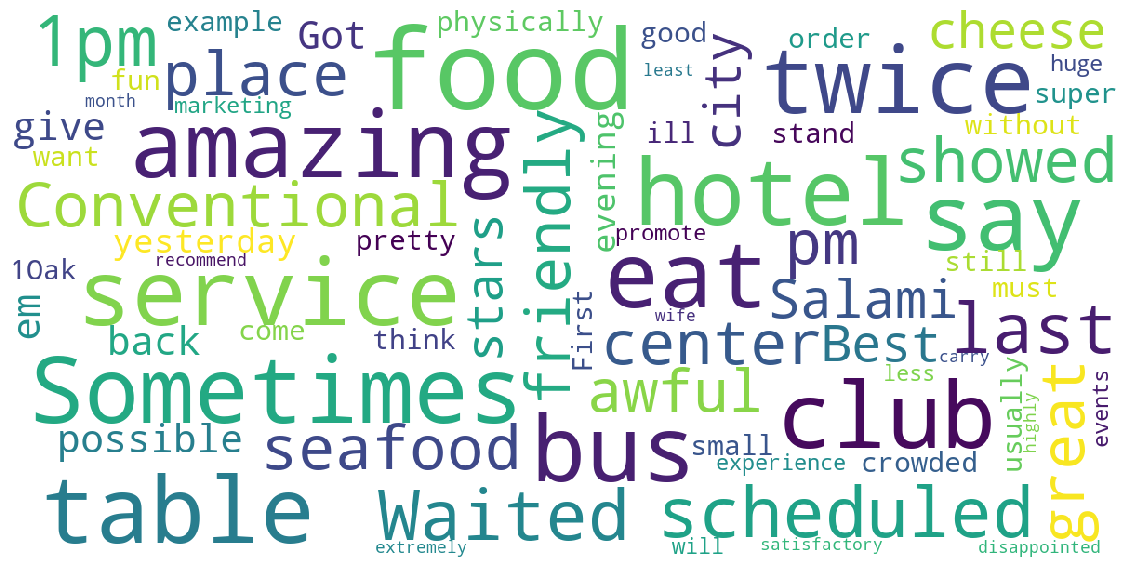

In [41]:
# visualization of word cloud 
show_wordcloud(pred_sentences)